In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import gc
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder,OneHotEncoder


In [2]:
path = '/Users/sheenmccullough/Documents/Kaggle/M5Forecasting/'

calendar = pd.read_csv(path+'calendar.csv')
trainData = pd.read_csv(path+'sales_train_validation.csv')
sellprices = pd.read_csv(path+'sell_prices.csv')

In [3]:
def Convert_to_transaction(df):
    
    '''
    convert our sales data into a daily transacitons set using the pandas melt function
    '''
    list_id_vars = ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'] 
    d_columns = df.drop(list_id_vars,axis=1)
    df_melted_sales = df.melt(id_vars = list_id_vars, value_vars = d_columns.columns, var_name = 'days', value_name = 'sales') 
    
    
    return df_melted_sales



In [4]:
# This usually takes 16-19 sec to run

train_df_melt = Convert_to_transaction(trainData)

In [5]:
#del train_df_melt
del trainData
gc.collect()

144

In [6]:
train_df_melt.head()

,id,item_id,dept_id,cat_id,store_id,state_id,days,sales
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0


In [7]:
train_df = pd.merge(train_df_melt,calendar[['d','wday','wm_yr_wk','event_name_1','date','year']],left_on='days',
                    right_on='d')

In [8]:
texas = train_df[train_df['state_id']=='TX']

In [9]:
daily_sales = texas.groupby(['date'])['sales'].sum()

### basic time series equation

$$ Sales_{t+1} = f(Sales_t,Sales_{t-1},Sales_{t-2},Sales_{t-3}....,error), $$
#### Where t+1 is the next day and t-1 is the previous day. T-2 is two days prior and so on..This simplistic model's future prediction is only based on past sales values, but not on any external variables which might affect sales. The error term on the right allows for random variation

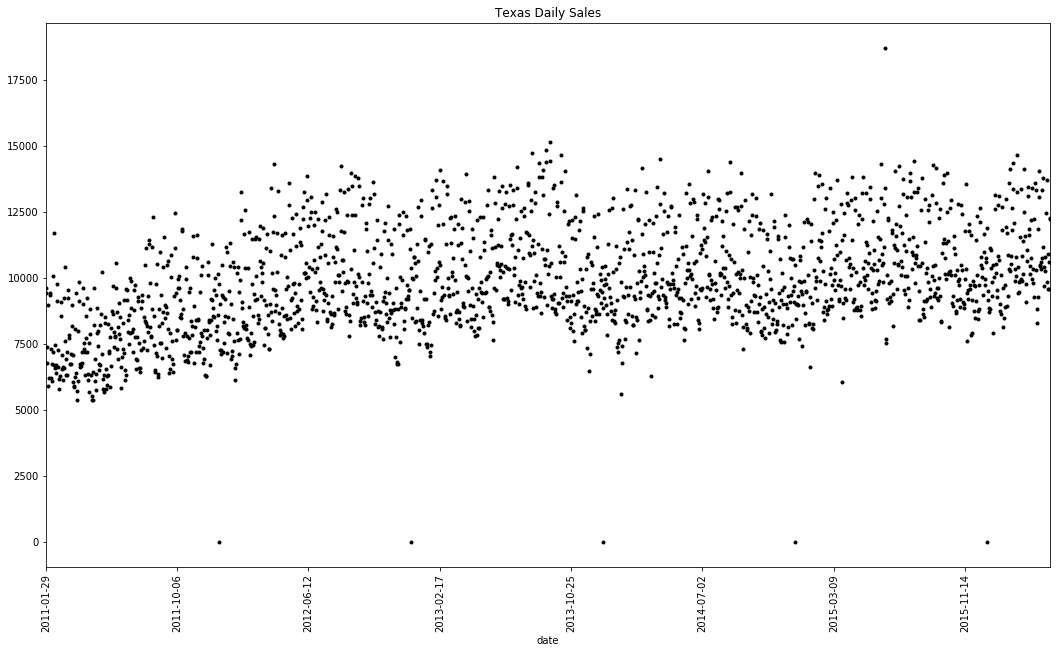

In [10]:
## texas daily sales
plt.title('Texas Daily Sales')
daily_sales.plot(style='k.',figsize=(18,10))
plt.xticks(rotation='vertical')
plt.show()


## seasonal plot

In [11]:
def seasonalplot(df):
    
    data=df[['year','date','sales']]
    unique_yrs = list(data['year'].drop_duplicates())
    for y in unique_yrs:
        yr_df = data[data['year']==y]
        yr_df['Month'] =pd.DatetimeIndex( yr_df['date']).month
        grpd = yr_df.groupby(['Month'])['sales'].sum()
        grpd.plot(figsize=(18,10))
    
    plt.legend(unique_yrs,fontsize=12,loc='upper left')
    plt.show()
    
        
    

In [ ]:
seasonalplot(texas)

In [ ]:
def subseriesboxplot(df):
    data=df[['year','date','sales']]
    dfgr = data.groupby(['date'])['sales'].sum().reset_index()
    dfgr['month'] = pd.DatetimeIndex(dfgr['date']).month
    
    plt.figure(figsize=(18,10))
    ax = sns.boxplot(x='month',y='sales',data=dfgr)
    print(dfgr['sales'].describe())
    
    

In [ ]:
subseriesboxplot(texas)

In [ ]:
def scatterbyday(df):
    data=df[['year','date','sales']]
    data['dayofyear'] = pd.DatetimeIndex(data['date']).dayofyear
    
    for y in list(data['year'].drop_duplicates()):
        dfgr = data[data['year']==y]
        dfgr = dfgr.groupby(['dayofyear'])['sales'].sum()
        dfgr.plot(figsize=(18,10))
    plt.legend(list(data['year'].drop_duplicates()),fontsize=12,loc='upper left')
    plt.show()
    
    dayofyear = data.groupby(['dayofyear'])['sales'].sum()
    dayofyear.plot(figsize=(18,10))

In [ ]:
scatterbyday(texas)

## Autocorrelation

just as correlation emasures the extent of a linear relationship between two variables, the autocorrelation measures the linear relationship between lagged values of a time series. 

$$ rk = \frac {\sum^T_{t=k+1} (y_t - ybar) (y_{t-k}-ybar)}{\sum^T_{t=1}(y_t - ybar)^2} $$

In [ ]:
autcorr= texas.groupby(['date'])['sales'].sum().reset_index()

In [ ]:
def autocorrelation(x, n_lags):
    autocorrels = {'lags':[],'autocorrelation':[]}
    for l in range(1,n_lags):
        mean = x.mean()
        normarray = x[:-l]
        lagarray= x[l:]
        numerator = sum([((yt-mean)*(ytk-mean)) for yt,ytk in zip(normarray,lagarray)])
        denominator = sum([(yt-mean)**2 for yt in normarray])
        
        autocorrels['lags'].append(l)
        if denominator!=0:
            val =numerator/denominator
            autocorrels['autocorrelation'].append(numerator/denominator)

            plt.vlines(l,0,(numerator/denominator))
        else:
            
            autocorrels['autocorrelation'].append(0)

            plt.vlines(l,0,(0))
            
         
    plt.plot(autocorrels['lags'],autocorrels['autocorrelation'],'bo')
    plt.hlines(0,0,n_lags+1)
    upperlimit = 2/np.sqrt(len(normarray))
    lowerlimit = -(2/np.sqrt(len(normarray)))
    plt.hlines(lowerlimit,0,n_lags+1,colors='b',linestyles='dashed')
    plt.hlines(upperlimit,0,n_lags+1,colors='b',linestyles='dashed')
    plt.show()


    return autocorrels


In [ ]:
#### there appears to be a weekly seasonal component based on the autocorrelation graph. r5,r6,r7 are higher than for other lags. These points are Friday, Saturday, and Sunday

In [ ]:

plt.figure(figsize=(30,10))
autocdf=autocorrelation(autcorr['sales'],n_lags=90)


plt.plot(autcorr['sales'])
plt.xlim(0,90)


print(

"There appears to be a weekly seasonal component based on the autocorrelation graph. \nR5,r6,r7 are higher than for other lags. These points are Friday, Saturday, and Sunday"
)

A slow decrease in the ACF as lags increase is due to an upward trend while a slow increase would be due to a 
downward trend. Our time series does not appear to have any sort of trend.

## Noise

For white noise series, we expect each autocorrelation to be close to zero. Of course, they will not be exactly equal to zero as there is some random variation. For a white noise series, we expect 95% of the spikes in the ACF to lie within  ±2/√T where  T is the length of the time series. It is common to plot these bounds on a graph of the ACF as seen above with the dashed blue lines. If one or more large spikes ar eoutside of these bounds, or if substantially more than 5% of the spikes are outside, then the series is probably not noise. 

## Simple Forecasting Methods

    1.) Average Method: Forecasts for all future values are euqal to the average of the historical data. 
    
$$ yhat_{T+h|T} = ybar = (y_1+....+y_T)/T $$
    
    2.) Naiive method
    3.) Seasonal Naiive Method
    4.) Drift Method

In [ ]:
train_df.head()

In [ ]:
samplesub = pd.read_csv(path+'sample_submission.csv')

In [ ]:
averageforcast = train_df.groupby(['id'])['sales'].mean().reset_index()

In [ ]:
train = train_df[train_df['date']<='2016-04-01']
validation = train_df[train_df['date']>'2016-04-01']

<br>

<br>

In [ ]:
def plotforecast(evaluate,train, graphtype='simple_average'):
    
    groupedevaldrft = evaluate.groupby(['date'])['predictedsales'].sum().reset_index()
    groupedevalsales = evaluate.groupby(['date'])['sales'].sum().reset_index()
    grouped = pd.merge(groupedevaldrft,groupedevalsales,on='date')
    trained = train.groupby(['date'])['sales'].sum().reset_index()
    grouped['residuals'] = grouped['sales']-grouped['predictedsales']
    
    
    forecastdays = pd.DataFrame({'days':grouped['date'].drop_duplicates()})
    forecastdays['days']= pd.to_datetime(forecastdays['days'])
    forecastdays['h'] = [(x-forecastdays['days'].min()).days for x in forecastdays['days']]
 
    


    grouped = pd.merge(grouped,forecastdays,left_on='date',right_on='days')

    stdv = grouped['residuals'].std()


    if graphtype == 'simple_average':
        grouped['upper95'] = grouped['predictedsales'] + (1.96*stdv) *np.sqrt((1+(1/len(grouped))))
        grouped['lower95'] = grouped['predictedsales'] - (1.96*stdv) *np.sqrt((1+(1/len(grouped))))

        grouped['upper80'] = grouped['predictedsales'] + (1.28*stdv)*np.sqrt((1+(1/len(grouped))))
        grouped['lower80'] = grouped['predictedsales'] - (1.28*stdv)*np.sqrt((1+(1/len(grouped))))





        plt.figure(figsize=(18,5))

        plt.plot(trained['date'],trained['sales'])
        plt.plot(grouped['date'],grouped['sales'])
        plt.plot(grouped['date'],grouped['predictedsales'])

        plt.plot(grouped['date'],grouped['upper95'],'b')
        plt.plot(grouped['date'],grouped['lower95'],'b')
        plt.plot(grouped['date'],grouped['upper80'],'b--',)
        plt.plot(grouped['date'],grouped['lower80'],'b--')

        plt.fill_between(grouped['date'], 
                         grouped['predictedsales'], 
                         grouped['upper80'], color='grey', alpha='0.5')


        plt.fill_between(grouped['date'], 
                         grouped['predictedsales'], 
                         grouped['lower80'], color='grey', alpha='0.5')


        plt.fill_between(grouped['date'], 
                         grouped['upper80'], 
                         grouped['upper95'], color='grey', alpha='0.3')


        plt.fill_between(grouped['date'], 
                         grouped['lower80'], 
                         grouped['lower95'], color='grey', alpha='0.3')




        plt.xlim('2016-01-01','2016-04-26')
        plt.show()

    elif graphtype =='naiive':
        grouped['upper95'] = grouped['predictedsales'] + (1.96*stdv) *np.sqrt(grouped['h'])
        grouped['lower95'] = grouped['predictedsales'] - (1.96*stdv) *np.sqrt(grouped['h'])

        grouped['upper80'] = grouped['predictedsales'] + (1.28*stdv)*np.sqrt(grouped['h'])
        grouped['lower80'] = grouped['predictedsales'] - (1.28*stdv)*np.sqrt(grouped['h'])





        plt.figure(figsize=(18,5))

        plt.plot(trained['date'],trained['sales'])
        plt.plot(grouped['date'],grouped['sales'])
        plt.plot(grouped['date'],grouped['predictedsales'])

        plt.plot(grouped['date'],grouped['upper95'],'b')
        plt.plot(grouped['date'],grouped['lower95'],'b')
        plt.plot(grouped['date'],grouped['upper80'],'b--',)
        plt.plot(grouped['date'],grouped['lower80'],'b--')

        plt.fill_between(grouped['date'], 
                         grouped['predictedsales'], 
                         grouped['upper80'], color='grey', alpha='0.5')


        plt.fill_between(grouped['date'], 
                         grouped['predictedsales'], 
                         grouped['lower80'], color='grey', alpha='0.5')


        plt.fill_between(grouped['date'], 
                         grouped['upper80'], 
                         grouped['upper95'], color='grey', alpha='0.3')


        plt.fill_between(grouped['date'], 
                         grouped['lower80'], 
                         grouped['lower95'], color='grey', alpha='0.3')




        plt.xlim('2016-01-01','2016-04-26')
    

Simple Average

$$ yhat_{T+h|T} = ybar = (y_1+....+y_T)/T $$



In [ ]:

def simplemean(train,validation):
    simplemean = train.groupby(['id'])['sales'].mean().reset_index()
    simplemean.columns= ['id','predictedsales']
    evaluate = pd.merge(validation[['id','sales','date']],simplemean,on='id')
    evaluate['residuals'] = evaluate['sales']-evaluate['predictedsales']
 
    
  
    
    rmse= np.sqrt(mean_squared_error(evaluate['sales'],evaluate['predictedsales']))
    print("RMSE is {}".format(rmse))
    
    #plotforecast(evaluate,train,graphtype='simple_average')
    
    

    return rmse


In [ ]:
simplemean(train,validation)

$$ Naiive Method $$
$$ yhat_{T+h|T}=y_T $$

#simply set all forecasts to be the value of the last observation

In [ ]:
x1 = train[train['id']=='HOBBIES_1_002_CA_1_validation']
v1 = validation[validation['id']=='HOBBIES_1_002_CA_1_validation']




In [ ]:
def naiveforecast(train,validation):
    maxdate = train['date'].max()
    maxdatedf = train[train['date']==maxdate]
    maxdatedf=maxdatedf[['id','sales']]
    maxdatedf.columns = ['id','predictedsales']
    evaluate = pd.merge(validation[['id','sales','date']],maxdatedf,on='id')
    rmse= np.sqrt(mean_squared_error(evaluate['sales'],evaluate['predictedsales']))
    
    print("RMSE is {}".format(rmse))
    #plotforecast(evaluate,train,graphtype='naiive')
   
    return rmse

In [ ]:
naiveforecast(train,validation)

## Moving Average

$$ yhat_{T+h|T} = \frac{1}{d} * \sum^T_{T-d}y_n $$

In [ ]:
train.head()

In [ ]:
def MAPred(train,validation,id_,MA=90):

    x1 = train[train['id']==id_]
    v1 = validation[validation['id']==id_]


    

    predictions = []
    for i in range(len(v1)):
        if i ==0:
            pred = np.mean(x1['sales'][-MA:])
            predictions.append(pred)

        elif i < MA+1 and i > 0:

            pred = .5* (np.mean(x1['sales'][-MA+i:]) + np.mean(predictions[:i]))
            predictions.append(pred)
        elif i > MA+1:

            predictions.append(np.mean(predictions[:i]))
            
            
    return predictions


  

In [ ]:
import random
def RunMA(train,validation):
    
    preds = []
    uniqueids = list(train['id'].drop_duplicates())
    random.shuffle(uniqueids)
    random.shuffle(uniqueids)
  
    for id_ in uniqueids[0:5]:
        MovingAvg = MAPred(train,validation,id_,MA=30)
        preds.append(tuple([id_,list(MovingAvg)]))
        
    return preds

In [ ]:
predlist = RunMA(train,validation)

In [ ]:
predlist

In [ ]:

v1_001 = validation[validation['id']==predlist[0][0]]
v1_001['90dMA'] = predlist[0][1]

plt.figure(figsize=(30,10))
autocdf=autocorrelation(v1_001['90dMA'],n_lags=15)

plt.xticks(rotation=70)


plt.plot(v1_001['date'],v1_001['90dMA'])



In [ ]:
plt.xticks(rotation=70)
plt.plot(v1_001['date'],v1_001['90dMA'] )
plt.plot(v1_001['date'],v1_001['sales'] )
print(np.sqrt(mean_squared_error(v1_001['sales'],v1_001['90dMA'])))

In [ ]:
v1_001['residuals'] = v1_001['sales']-v1_001['90dMA']

plt.xticks(rotation=70)

plt.plot(v1_001['date'],v1_001['residuals'],'o--' )




We set each forecast to be equal to the last observation value from the same point on time of the year before

$$ Seasonal Naiive Method $$
$$ yhat_{T+h|T} = y_{T+h - m(k+1)} $$

Where m is the seasonal period and k is the ineger part of (h-1)/m 
With quarterly data, the forecast of all future Q2 values is equal to the last observed Q2

In [ ]:
def seasonalnaiveforecast(train,validation):
    validation['date']= pd.to_datetime(validation['date'])
    train['date']= pd.to_datetime(train['date'])


    validation = validation[['id','sales','date']]
    validation['t-1'] = validation['date']- pd.Timedelta(days=365) 
    seasonal = train[['id','date','sales']]
    seasonal.columns = ['id','date','predictedsales']
    evaluate = pd.merge(validation,seasonal,left_on=['id','t-1'],
                       right_on=['id','date'])
   




    return rmse

In [ ]:
seasonalnaiveforecast(train,validation)

### Drift Method
    -A variation of the naiive method is to allow forecast to increase or decrease over time, where the amount
    
    of the change over time (the *drift*) is set to be the average change seen in the historical data.
    
$$ yhat_{T+h|T} = y_T + h\frac{y_t - y_1}{T - T_0}$$ 

In [ ]:

def driftmethodforecast(train,validation):
    
    
    y_t_df = train[train['date']==train['date'].max()][['id','sales']]
    y_0_df = train[train['date']==train['date'].min()][['id','sales']]
    y_t_df.columns=['id','salesT']
    y_0_df.columns=['id','sales0']
    valcounts = train['id'].value_counts().reset_index()
    valcounts.columns=['id','counts']

    m_df = pd.merge(pd.merge(y_t_df,y_0_df,on='id'),valcounts,on='id')
    m_df['slope'] = (m_df['salesT']-m_df['sales0'])/m_df['counts']


    forecastdays = pd.DataFrame({'days':validation['date'].drop_duplicates()})
    forecastdays['h'] = [(x-forecastdays['days'].min()).days for x in forecastdays['days']]

    evaluationdf = pd.merge(validation[['id','date','sales']],forecastdays,left_on='date',right_on='days')

    evaluationdf = pd.merge(evaluationdf,m_df,on='id')


    evaluationdf['drift_forecast'] = evaluationdf['salesT'] + (evaluationdf['slope'] * evaluationdf['h'])
    
    

    rmse= np.sqrt(mean_squared_error(evaluationdf['sales'],evaluationdf['drift_forecast']))

    print("RMSE is {}".format(rmse))
    
    return rmse

In [ ]:
driftmethodforecast(train,validation)

### Simple linear Regression for time series 

$$ yt = B_0 + B_1x_t + E_t $$

In [ ]:
trainset = train[train['id']=='FOODS_1_085_TX_3_validation'] 
testset = validation[validation['id']=='FOODS_1_085_TX_3_validation'] 

In [ ]:
train_df = trainset[['date','sales']]
train_df.set_index('date',inplace=True)
train_df['datetime'] = np.array(pd.to_datetime(train_df['sales'].dropna()).index.values, dtype=float)
train_df.reset_index(inplace=True)



test_df = testset[['date','sales']]
test_df.set_index('date',inplace=True)
test_df['datetime'] = np.array(pd.to_datetime(test_df['sales'].dropna()).index.values, dtype=float)

In [ ]:

def SlopeCoeff(data=df,target='sales',feature='TV'):
    sq = [(x-data[feature].mean())**2 for x in data[feature]]
    div = [(x-data[feature].mean())*(y-data[target].mean()) for x,y in zip(data[feature],data[target])]
    coeff = sum(div)/sum(sq)
    return coeff
slope = SlopeCoeff(data=train_df,target='sales',feature='datetime')

In [ ]:
def Intercept(y,x,slope):
    intercept = y.mean()-(slope*x.mean())
    return intercept


itercept = Intercept(train_df['sales'],train_df['datetime'],slope)


In [ ]:
def predict(X):
    predictions = [intercept + (slope*x) for x in X]
    return predictions

test_df['predictions'] = predict(test_df['datetime'])

    
    

In [ ]:
plt.xticks(rotation=90)
plt.plot(test_df['predictions'])
plt.plot(test_df['sales'])

In [ ]:
print(np.sqrt(mean_squared_error(test_df['sales'],test_df['predictions'])))

In [ ]:


plt.figure(figsize=(30,10))
autocdf=autocorrelation(test_df['predictions'],n_lags=10)
plt.xticks(rotation=70)
plt.plot(test_df['predictions'])

In [ ]:
trainset.index = pd.to_datetime(trainset.date)
y = trainset.sales
ax = y.plot()
ax.set_ylabel("Sales")
y.head()

In [ ]:
y.loc['2015-02-01':'2015-02-11'].plot();

## let's try to predict the next day of data

In [ ]:
testset.index = pd.to_datetime(testset.date)
y_test = testset.sales
ax = y_test.plot()
ax.set_ylabel("Sales")
y_test.head(100)

In [ ]:
known = y
unknown = y_test['2016-04-02':'2016-04-24']
to_predict = y_test['2016-04-09':'2016-04-09']

plt.figure(figsize=(18,10))
fig, ax = plt.subplots(figsize=(18,10));
known.plot(ax=ax, c='c', zorder=3);
unknown.plot(ax=ax, c='black', alpha=0.5);
to_predict.plot(ax=ax, c='r', marker='*', markersize=16,
                linestyle='');
plt.xlim('2015-08-01','2016-04-24');
ax.legend(['known', 'future', 'value to predict']);
ax.set_ylabel('sales');


In [ ]:
y_all = pd.concat([y,y_test])
y_all

In [ ]:
start = np.where(y_all.index =='2011-01-29')[0][0]
middle = np.where(y_all.index =='2016-04-13')[0][0]

end = np.where(y_all.index == '2016-04-24')[0][0]
window = 50


plt.figure(figsize=(18,10))


fig, ax = plt.subplots(figsize=(18,10));

for i in range(8):

    full = y_all.iloc[start:end]
    train =y_all.iloc[middle - i - window:middle - i ]
    predict = y_all.iloc[middle - i:middle - i + 1]

    (full + 2*i).plot(ax=ax, c='grey', alpha=0.5);
    (train + 2*i).plot(ax=ax, c='c', markersize=4,
                       marker='o')
    (predict + 2*i).plot(ax=ax, c='r', markersize=8,
                         marker='o', linestyle='')

    plt.xlim('2016-03-31','2016-04-24');


plt.show()    
ax.get_yaxis().set_ticks([]);
ax.legend(['full time series',
           '$\mathbf{X}$',
           '$y$'],
          bbox_to_anchor=(1, 1));

plt.show()

In [ ]:
full = y_all.iloc[start:end]
full.plot(c='grey', alpha=0.5)


In [ ]:
np.where(y_test.index=='2016-04-13')

In [ ]:
y_all.iloc[middle - 1:middle - 1 ]

In [ ]:
y_all.iloc[middle - 1- window:middle - 1].index

In [ ]:
window = 120
num_samples = 200
X_mat = []
X_pred_date = []
y_mat = []
for i in range(num_samples):
    # Slice a window of features
    X_mat.append(y_all.iloc[middle - i - window:middle - i].values)
    y_mat.append(y_all.iloc[middle - i:middle - i + 1].values)
    X_pred_date.append(tuple([str(pd.to_datetime(np.max(y_all.iloc[middle - i - window:middle - i].index)).month)+"/"+
                              str(pd.to_datetime(np.max(y_all.iloc[middle - i - window:middle - i].index)).day)+"/"+
                              str(pd.to_datetime(np.max(y_all.iloc[middle - i - window:middle - i].index)).year)]))
X_mat = np.vstack(X_mat)
X_pred_date = np.vstack(X_pred_date)
X_pred_date=np.concatenate(X_pred_date)
y_mat = np.concatenate(y_mat)

assert X_mat.shape == (num_samples, window)
assert len(y_mat) == num_samples

In [ ]:
y_test = y_mat[180:]

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

Xmat = pd.DataFrame(X_mat)

Xmat['Last_date']=X_pred_date
Xmat['Last_date']=pd.to_datetime(Xmat['Last_date']) 

Xmat['Target'] = y_mat

train_df = Xmat.iloc[0:180]
test_df = Xmat.iloc[180:]


Xmat.head()

#lr = RandomForestRegressor(n_estimators=1000,max_depth=10,min_samples_split=4)
#lr = lr.fit(train_df.drop('Target',axis=1), train_df['Target'])
#y_pred = lr.predict(test_df.drop('Target',axis=1))

In [ ]:
plt.plot(y_test)
plt.plot(y_pred)
np.sqrt(mean_squared_error(y_test,y_pred))



## y_mat


In [ ]:
list(X_pred_date)

In [ ]:
y_test

In [ ]:
Xmat